In [141]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from toolz import valmap
import pprint
import pandas as pd
import arviz as az
# get rid of warnings to make results less verbose
import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append('..')
import wismut.analyze_chains as ac
path = os.getcwd() + "/"

In [12]:
paths_corr_ehr = ac.search_files_by_name("beta.txt", f"../results/application/main_results/corrected_EHR")
paths_naive_ehr = ac.search_files_by_name("beta.txt", f"../results/application/main_results/uncorrected_EHR")
paths_corr_cox = ac.search_files_by_name("beta.txt", f"../results/application/main_results/corrected_cox")
paths_naive_cox = ac.search_files_by_name("beta.txt", f"../results/application/main_results/uncorrected_cox")

In [13]:
paths_corr = ac.search_files_by_name("beta.txt", f"/../results/application/corrected_EHR")
paths_uncor = ac.search_files_by_name("beta.txt", f"/../results/application/uncorrected_EHR")

samples = dict(
    ehr=dict(
        corrected=np.stack([np.loadtxt(paths_corr_ehr[i]) for i in range(8)]),
        uncorrected=np.stack([np.loadtxt(paths_naive_ehr[i]) for i in range(8)])
    ),
    cox=dict(
        corrected=np.stack([np.loadtxt(paths_corr_cox[i]) for i in range(8)]),
        uncorrected=np.stack([np.loadtxt(paths_naive_cox[i]) for i in range(8)])
    )
)    

## Main results 

In [ ]:
samples_flat = ac.dict_map(lambda x: x.flatten(), samples)
records = [
    {'value': v, 'Measurement error': correction, 'type': outer_key}
    for outer_key, inner_dict in samples_flat.items()
    for correction, values in inner_dict.items()
    for v in values
]
df = pd.DataFrame(records)

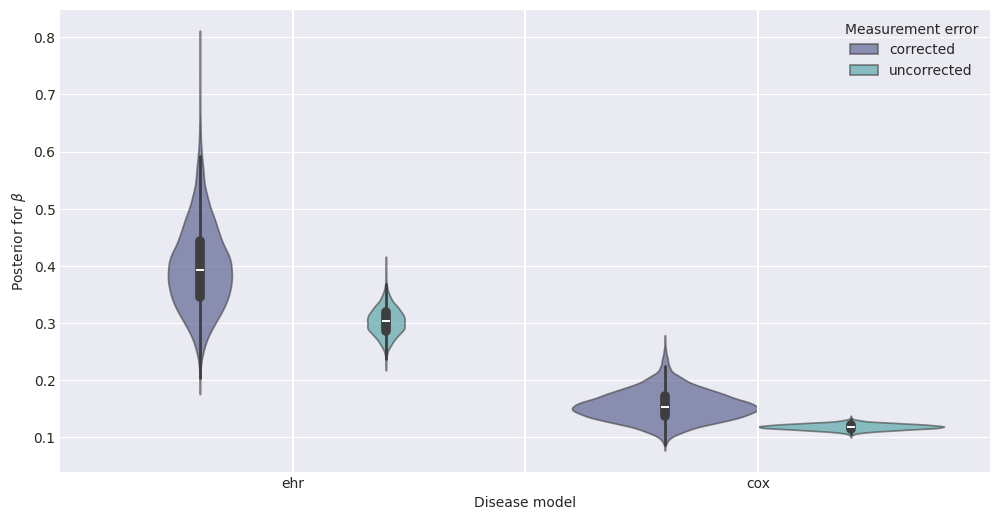

In [220]:
sns.set_style("darkgrid")
fig, axs = plt.subplots(1, 1, figsize=(12, 6))
axs.axvline(0.5, color="white")
axs.axvline(0, color="white")
axs.axvline(1, color="white")
sns.violinplot(data=df, x="type", y="value", hue="Measurement error", alpha=0.6, ax=axs, inner_kws=dict(box_width=7, whis_width=2), palette="mako")
axs.set_ylabel(r'Posterior for $\beta$')
axs.set_xlabel(r'Disease model')
plt.savefig("plots/results_application.pdf")

In [238]:
pprint.pprint(ac.dict_map(lambda x: np.round(x, 4), ac.dict_map(lambda x: dict(mean=x.mean(), median=np.median(x), hdi=az.hdi(x)), samples_flat)))

{'cox': {'corrected': {'hdi': array([0.1066, 0.2032]),
                       'mean': 0.1553,
                       'median': 0.1532},
         'uncorrected': {'hdi': array([0.1088, 0.1275]),
                         'mean': 0.1181,
                         'median': 0.1181}},
 'ehr': {'corrected': {'hdi': array([0.2614, 0.5352]),
                       'mean': 0.3977,
                       'median': 0.3917},
         'uncorrected': {'hdi': array([0.2567, 0.3471]),
                         'mean': 0.3028,
                         'median': 0.3025}}}


## Convergence diagnostics

#### Rhats

In [ ]:
rhats = ac.dict_map(lambda x: round(az.rhat(x), 3), samples)
pprint.pprint(rhats)

#### Trace plots

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(10, 6))
plt.style.use('seaborn-v0_8-darkgrid')

axs[0,0].plot(samples["cox"]["corrected"].T, alpha=0.3)
axs[0,0].set_title("Cox, with ME correction")
axs[0,0].annotate(f"$\\hat{{R}} = {rhats['cox']['corrected']}$", xy=(0, axs[0,0].get_ylim()[1]*0.93))


axs[1,0].plot(samples["cox"]["uncorrected"].T, alpha=0.3)
axs[1,0].set_title("Cox, without ME correction")
axs[1,0].annotate(f"$\\hat{{R}} = {rhats['cox']['uncorrected']}$", xy=(0, axs[1,0].get_ylim()[1]*0.973))

axs[0,1].plot(samples["ehr"]["corrected"].T, alpha=0.3)
axs[0,1].set_title("EHR, with ME correction")
axs[0,1].annotate(f"$\\hat{{R}} = {rhats['ehr']['corrected']}$", xy=(0, axs[0,1].get_ylim()[1]*0.93))

axs[1,1].plot(samples["ehr"]["uncorrected"].T, alpha=0.3)
axs[1,1].set_title("EHR, without ME correction")
axs[1,1].annotate(f"$\\hat{{R}} = {rhats['ehr']['uncorrected']}$", xy=(0, axs[1,1].get_ylim()[1]*0.96))

fig.suptitle(r'Traceplots for $\beta$')
plt.savefig("plots/traceplots_application.pdf")